
# CO-OCURRENCIAS (TCOR)
### Mateo Serrato Ascencio



Cuenta el numero de veces que aparece una palabra en dos documentos usando una matriz de co-ocurrencias

In [129]:
def get_text_from_files(path_corpus, path_truth):
    tr_text = [] #aqui van los tuits
    tr_labels = [] #aqui van las etiquetas

    with open(path_corpus, 'r', encoding='utf-8') as f_corpus, open(path_truth, 'r', encoding='utf-8') as f_truth:

        for twitt in f_corpus:
            tr_text += [twitt]

        for label in f_truth:
            tr_labels += [label]

    return tr_text, tr_labels

tr_text, tr_labels = get_text_from_files('./mex20_train.txt','mex20_train_labels.txt' )



Counter({'0\n': 3759, '1\n': 1519})


Text(0.5, 0, 'Etiqueta')

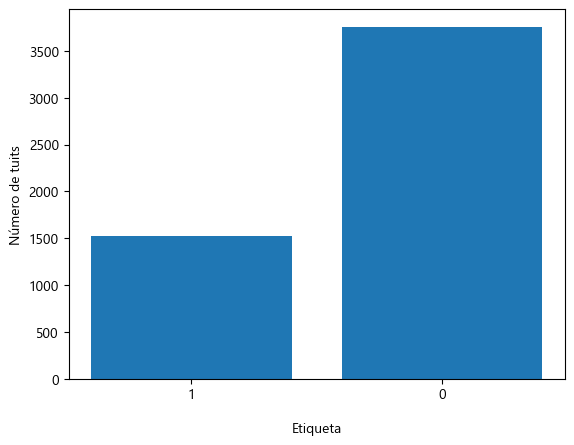

In [130]:
from collections import Counter
import matplotlib.pyplot as plt

print(Counter(tr_labels))
plt.bar(Counter(tr_labels).keys(), Counter(tr_labels).values())
plt.ylabel('Número de tuits')
plt.xlabel('Etiqueta')



TOKENIZAMOS

In [131]:
import nltk
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

corpus_palabras = []

for tweet in tr_text:
    corpus_palabras+= tokenizer.tokenize(tweet)

FRECUENCIAS DE TOKENS 

In [132]:
fdist = nltk.FreqDist(corpus_palabras)

In [133]:
fdist

FreqDist({',': 3016, 'de': 2915, 'que': 2829, '.': 2604, 'la': 2031, 'a': 1956, 'y': 1856, '!': 1435, 'no': 1430, '@USUARIO': 1399, ...})

Ordenamos dichas frecuencias  y reducimos diccionario

In [134]:

import numpy as np
def sort_freq(fdist):
    aux = [(fdist[key], key) for key in fdist]
    aux.sort(reverse=True) 
    return aux

V = sort_freq(fdist)[:5000]  #las 15000 palabras más frecuentes


In [135]:
dict_indices = dict()

cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1

In [136]:

def build_bow_tr(tr_text,V, dict_indices):
    tokenizer = TweetTokenizer()
    
    # Crear matriz vacía
    BOW = np.zeros((len(tr_text), len(V)), dtype=int)
    
    # Recorremos cada tweet
    cont_doc=0
    for i, tr in enumerate(tr_text):
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices:  #Si la palabra está en el vocabulario
                BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
        cont_doc += 1
        
    

    return BOW



In [137]:
BOW_tr = build_bow_tr(tr_text, V, dict_indices)
BOW_tr
BOW_tr.shape

(5278, 5000)

## CONSTRUIMOS MATRIZ DE CO-OCURRENCIAS DE TÉRMINO VS TÉRMINO

In [138]:
def compute_tcor(BOW):
    
    DTR = np.zeros((BOW.shape[1], BOW.shape[1]), dtype =np.float64)
    
    print("la matriz de Termino X Termino es de:", DTR.shape)
    print("La matriz de Documento X Termino es de:", BOW.shape)
    
    
    for doc, i in zip(BOW, range(len(BOW))):
        nonzero_positions = np.nonzero(doc)[0]
        for t1 in nonzero_positions:
            for t2 in nonzero_positions:
                DTR[t1, t2] += 1.0
                
    V_size = BOW.shape[1]
    W = []
    for index_word in range(V_size):
        co_occurrences = float(np.size(np.where(DTR[index_word,:] > 0), axis=1))
        if co_occurrences > 0:
            W += [V_size/co_occurrences]
        else:
            W += [1]
    W = np.array(W).reshape(1,V_size)
 
    DTR[np.where(DTR > 0)] = (1 + np.log10(DTR[np.where(DTR > 0)]))  
    DTR = DTR * np.log10(W)
        
    
    return DTR


In [139]:
np.nonzero(BOW_tr[5000])[0]

array([   7,   27,   43,   55,  104,  113,  131,  207,  550,  576, 1288])

In [140]:
from sklearn import preprocessing
TCOR_base = compute_tcor(BOW_tr)
TCOR_base = preprocessing.normalize(TCOR_base, norm = 'l2')

la matriz de Termino X Termino es de: (5000, 5000)
La matriz de Documento X Termino es de: (5278, 5000)


## FEATURE SELECTION

In [141]:
from sklearn.feature_selection import SelectKBest, chi2

feats = SelectKBest(chi2, k=1000)
feats.fit(BOW_tr,tr_labels)
best = feats.get_support(indices=True)


In [142]:
best

array([   0,    1,    2,    4,    5,    7,    9,   10,   11,   12,   13,
         17,   18,   19,   22,   24,   25,   28,   30,   32,   35,   36,
         37,   38,   39,   41,   43,   44,   47,   48,   49,   50,   51,
         53,   54,   56,   57,   58,   59,   61,   63,   64,   65,   66,
         67,   69,   70,   71,   74,   78,   79,   85,   86,   87,   88,
         89,   92,   93,   94,   97,  100,  102,  103,  104,  105,  107,
        108,  109,  110,  111,  114,  115,  116,  117,  118,  119,  120,
        122,  123,  124,  125,  128,  129,  131,  133,  134,  135,  136,
        140,  143,  147,  148,  150,  151,  153,  154,  155,  157,  160,
        162,  163,  164,  166,  167,  170,  177,  178,  179,  181,  182,
        184,  185,  186,  187,  188,  191,  192,  193,  200,  201,  207,
        209,  211,  216,  217,  221,  222,  225,  230,  231,  233,  235,
        236,  237,  239,  240,  243,  245,  246,  248,  249,  250,  252,
        253,  256,  257,  258,  259,  260,  264,  2

In [143]:
dict_indices_invertido = {}
for w in dict_indices:
    dict_indices_invertido[dict_indices[w]] = w

dict_indices_invertido

{0: ',',
 1: 'de',
 2: 'que',
 3: '.',
 4: 'la',
 5: 'a',
 6: 'y',
 7: '!',
 8: 'no',
 9: '@USUARIO',
 10: 'me',
 11: 'el',
 12: 'en',
 13: 'se',
 14: 'es',
 15: 'con',
 16: '?',
 17: 'verga',
 18: 'los',
 19: 'madre',
 20: 'por',
 21: 'las',
 22: '"',
 23: 'un',
 24: 'te',
 25: 'mi',
 26: 'lo',
 27: 'putas',
 28: 'una',
 29: '...',
 30: 'putos',
 31: 'para',
 32: '😂',
 33: 'si',
 34: 'ya',
 35: 'como',
 36: 'su',
 37: 'pero',
 38: 'tu',
 39: 'loca',
 40: 'le',
 41: 'más',
 42: 'No',
 43: 'del',
 44: 'gorda',
 45: 'al',
 46: 'bien',
 47: 'A',
 48: '¿',
 49: 'Y',
 50: 'son',
 51: 'Me',
 52: 'o',
 53: 'feas',
 54: 'cuando',
 55: 'Que',
 56: ':',
 57: 'yo',
 58: 'les',
 59: 'porque',
 60: 'ni',
 61: 'está',
 62: 'ser',
 63: 'estoy',
 64: 'sus',
 65: 'todos',
 66: 'esta',
 67: 'puta',
 68: 'Ya',
 69: 'todo',
 70: 'pinche',
 71: 'puto',
 72: 'tan',
 73: 'Si',
 74: 'La',
 75: 'qué',
 76: '…',
 77: 'eso',
 78: 'muy',
 79: 'soy',
 80: 'hasta',
 81: 'así',
 82: '¡',
 83: '<URL>',
 84: 'mamar',


In [144]:
target_words = [dict_indices_invertido[index] for index in best]
t_words = target_words
target_matrix = np.array([TCOR_base[dict_indices[word]] for word in t_words])
target_matrix.shape

(1000, 5000)

## CONSTRUIMOS LA MATRIZ TCOR DE LAS MEJORES 1000 PALABRAS

In [145]:
target_matrix.shape

(1000, 5000)

In [146]:
from tsne import tsne 
reduced_matrix = tsne(target_matrix,2)



Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.159072
Iteration 10: error is 17.833756
Iteration 20: error is 16.888188
Iteration 30: error is 16.710103
Iteration 40: error is 16.781154
Iteration 50: error is 16.720166
Iteration 60: error is 16.695781
Iteration 70: error is 16.865968
Iteration 80: error is 16.719342
Iteration 90: error is 16.860750
Iteration 100: error is 16.800008
Iteration 110: error is 2.143297
Iteration 120: error is 1.668199
Iteration 130: error is 1.480107
Iteration 140: error is 1.373228
Iteration 150: error is 1.298815
Iteration 160: error is 1.234022
Iteration 170: error is 1.180328
Iteration 180: error is 1.151481
Iteration 190: error is 1.130475
Iteration 200: error is 1.114679
Iteration 210: error is 1.101945
Iteration 220: error is 1.091314
Iteration 230: error is 1.082425
Iteration 240: error is 1.075026
Iteration 250: error is

## VISUALIZACIÓN

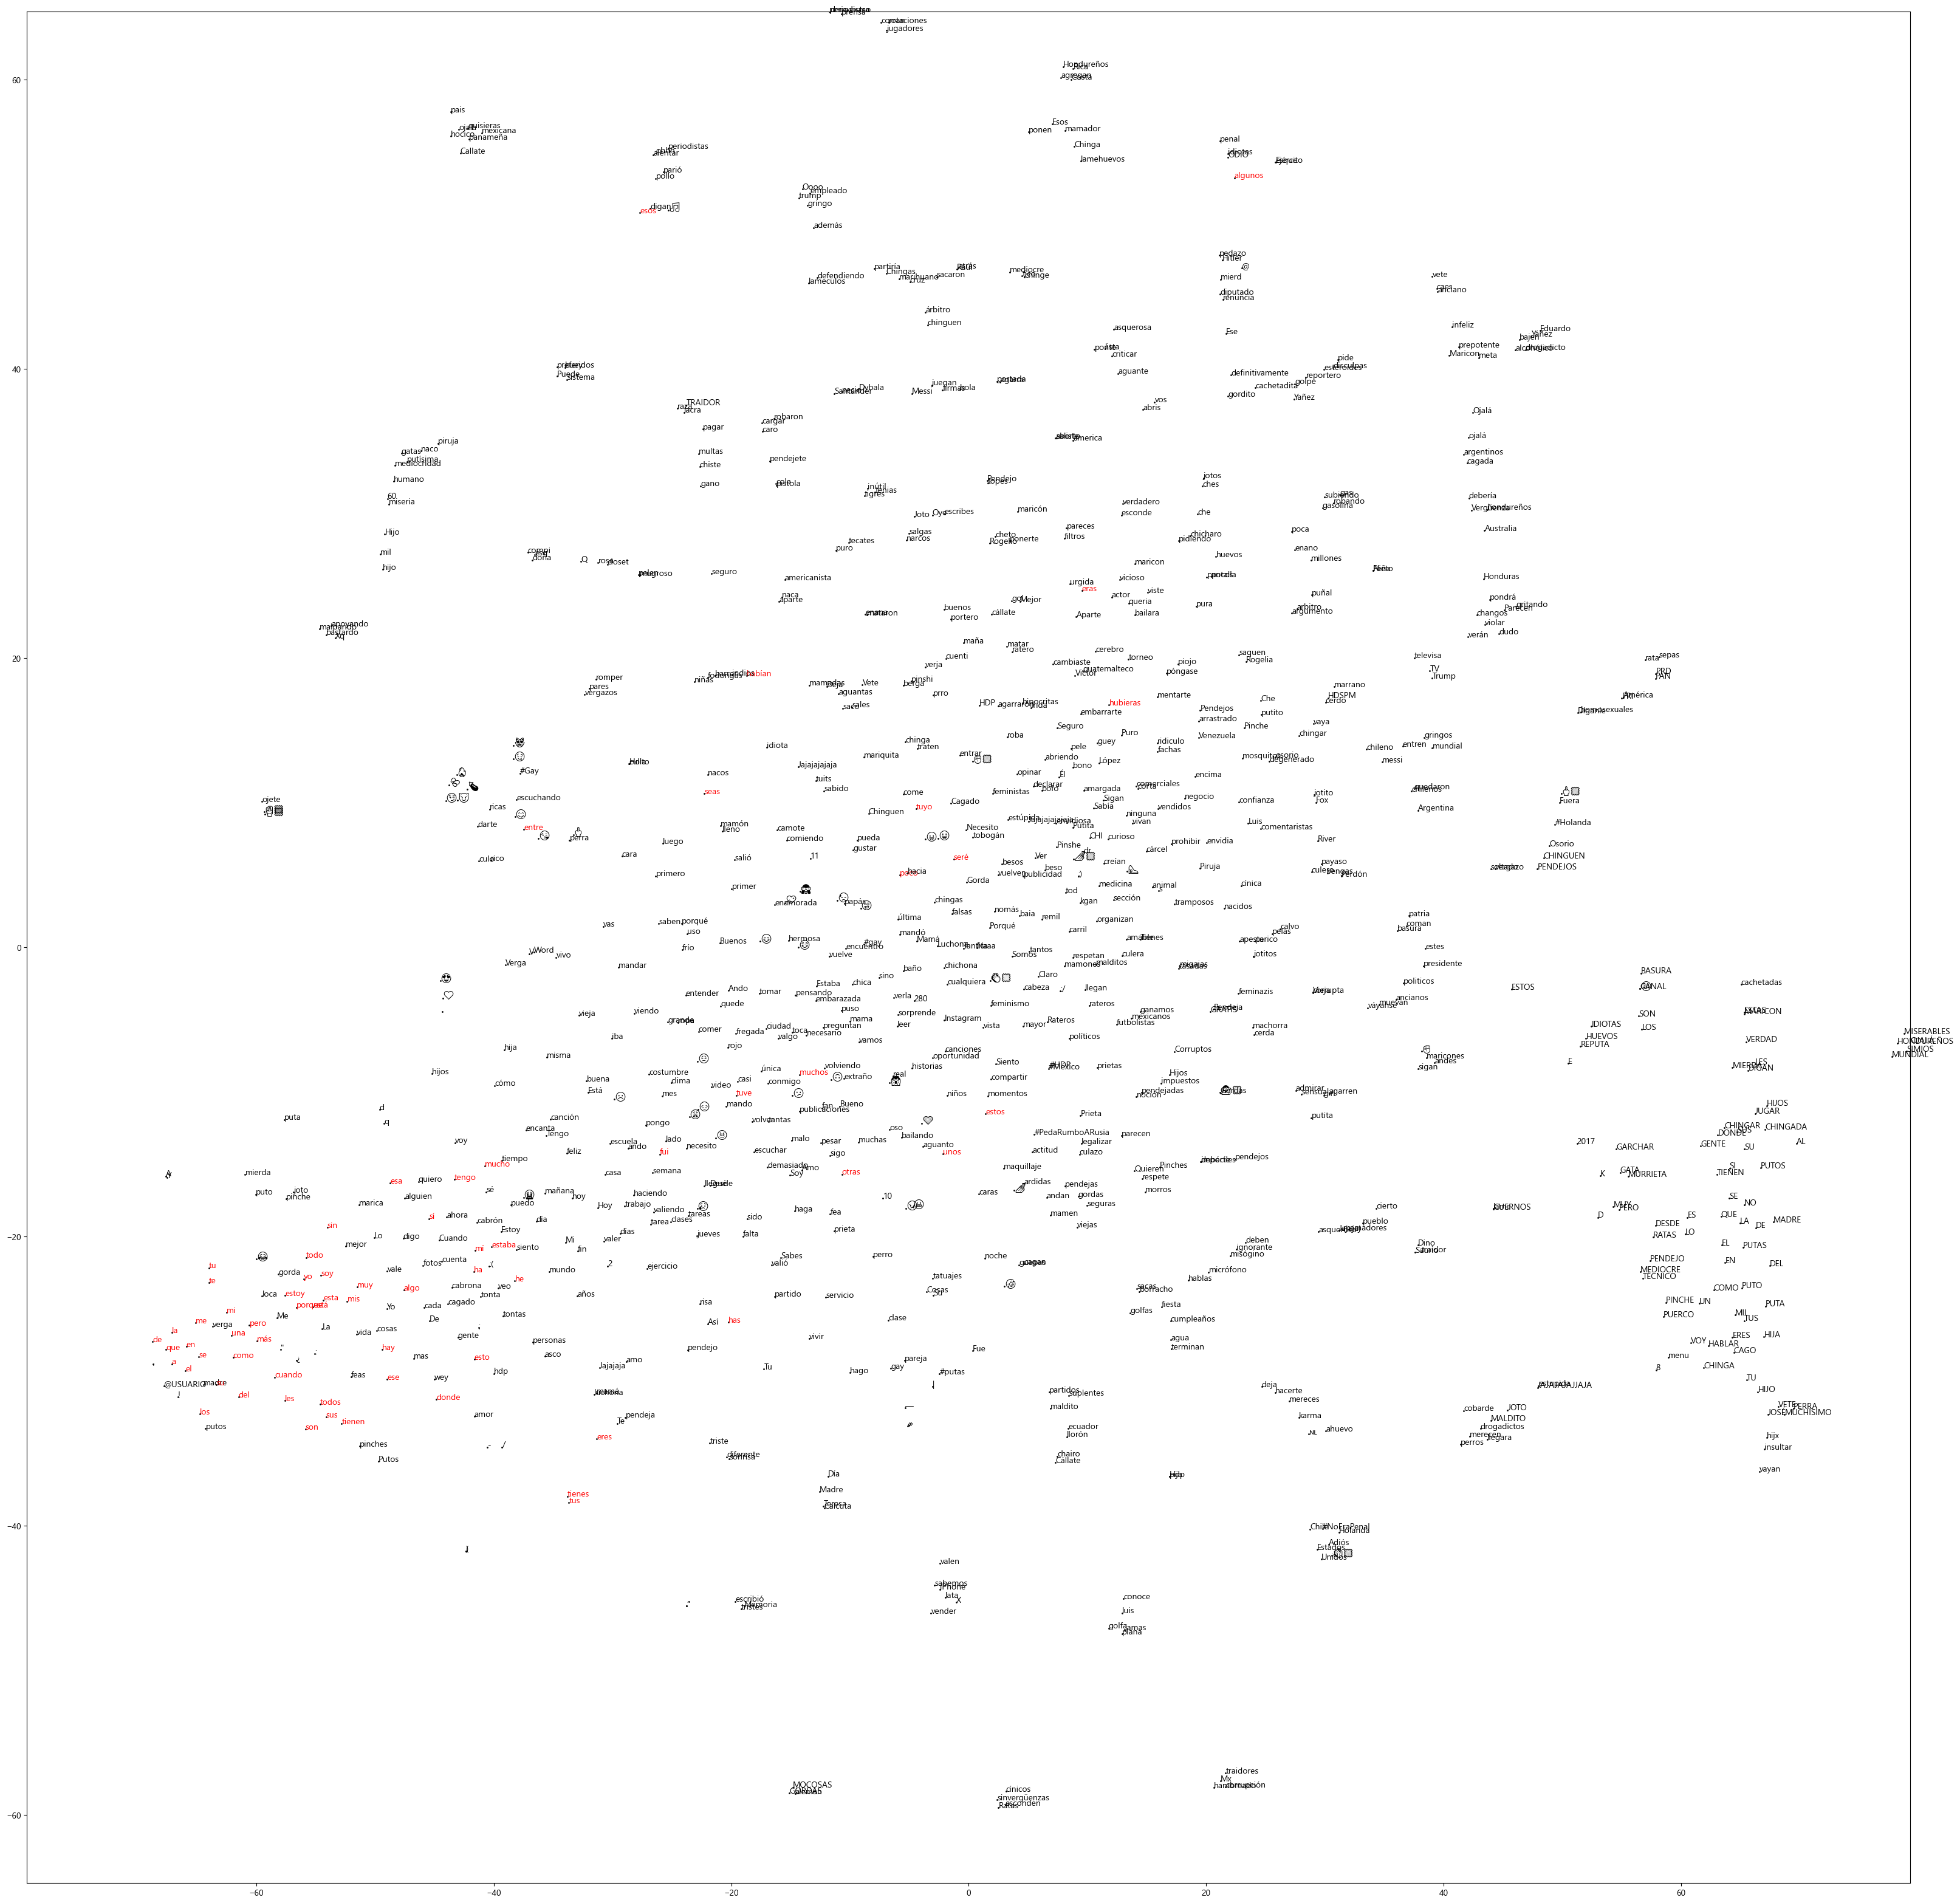

In [147]:
max_x = np.amax(reduced_matrix,axis=0)[0]


max_x


max_y = np.amax(reduced_matrix,axis=0)[1]


max_y

# %%
import matplotlib.pyplot as plt 
plt.rcParams['font.family'] = 'Segoe UI Emoji'
plt.figure(figsize=(40,40),dpi=100)
plt.xlim((-max_x,max_x))
plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:,0],reduced_matrix[:,1],1, color = 'black')
w
from nltk.corpus import stopwords
sw = set(stopwords.words('spanish'))
for idx, word in enumerate(t_words[:]):
    #coords para pintar la palabra
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    

    if word in sw:
        plt.annotate(word,(x,y),color = 'red')

    else:
        plt.annotate(word,(x,y),color = 'black')





Vemos que a fin de cuentas, usemos Dor o usemos TCOR obtenemos el DTR, Dor compara documento vs término mientras que TCOR nos dice que palabras aparecen juntas dentro de los documentos, creo yo que es mejor usar TCOR para este caso, ya que une terminos por su contexto segun como aparezcan juntas las palabras, por ejemplo, usando TCOR vi que aparecen "pareja" y "gay" juntos, aunque las palabras no tengan mucha relación entre ellas de manera directa, la frase "pareja gay" se usa mucho en este corpus, en DOR encontre un ejemplo de "vivan" y "matar", palabras las cuales pueden tener relación si las ordenamos en nuestro campo vectorial de dos dimensiones dado por DOR, pero, en realidad "vivan matar" no es una frase usada comunmente, de haberlo hecho con TCOR no saldríasn juntas dichas palabras
